# Annotations de manoeuvres

## Importation des données

In [1]:
#!pip install pandas matplotlib

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from cv2 import norm
from numpy import arange

import wandb
import sys
import logging
import os
from os.path import abspath, dirname, join
from genericpath import isfile
import itertools
from tqdm import tqdm
import pprint
from pathlib import Path
import threading
import time
from datetime import date, timedelta, datetime
import json
from httpx import ReadTimeout
from re import M
import itertools

from spacetrack import SpaceTrackClient
import spacetrack.operators as op

from merlion.models.anomaly.autoencoder import AutoEncoder
from merlion.models.anomaly.vae import VAE
from merlion.models.anomaly.isolation_forest import IsolationForest
from merlion.evaluate.anomaly import TSADMetric
from merlion.plot import plot_anoms
from merlion.models.factory import ModelFactory
from merlion.post_process.threshold import AggregateAlarms
from ts_datasets.anomaly import CustomAnomalyDataset
from merlion.utils import TimeSeries


rootdir = Path().resolve()

DORIS_system_maneuvers = pd.read_csv(join(rootdir, 'data', 'maneuvers', 'DORIS_system_maneuvers.csv'), delimiter=";")
maneuvers_df=DORIS_system_maneuvers.copy()

dict_satellites_norad_ids =	{
  "CRYOSAT2": 36508,
  "ENVISAT": 27386,
  "HY2A": 43682,
  "HY2C": 46469,
  "HY2D": 48621,
  "JASON1": 26997,
  "JASON2": 33105,
  "JASON3": 41240, 
  "SARAL": 39086,
  "SENTINEL-3A": 41335,
  "SENTINEL-3B": 43437,
  "SENTINEL-6A": 46984,
  "SPOT2": 20436,
  "SPOT4": 25260,
  "SPOT5": 27421,
  "SWOT": 54754,
}

dict_satellites_names =	{
  36508: "CRYOSAT2",
  27386: "ENVISAT",
  43682: "HY2A",
  46469: "HY2C",
  48621: "HY2D",
  26997: "JASON1",
  33105: "JASON2",
  41240: "JASON3", 
  39086: "SARAL",
  41335: "SENTINEL-3A",
  43437: "SENTINEL-3B",
  46984: "SENTINEL-6A",
  20436: "SPOT2",
  25260: "SPOT4",
  27421: "SPOT5",
  54754: "SWOT",
}

# Define labels for y-axes
parameters_unit = {
    "INCLINATION": "(degrees)",
    "RA_OF_ASC_NODE": "(degrees)",
    "ECCENTRICITY": "no unit",
    "ARG_OF_PERICENTER": "(degrees)",
    "MEAN_ANOMALY": "(degrees)",
    "MEAN_MOTION": "(rev. per day)",
    "APOGEE": "km",
    "PERIGEE": "km",
    "SEMIMAJOR_AXIS": "km"
}

## Traitement du dataframe
# Combine "Start Date" and "Start Hour" into a single datetime column
maneuvers_df['Start DateTime'] = pd.to_datetime(maneuvers_df['Start Date'] + ' ' + maneuvers_df['Start Hour'], format="%d/%m/%Y %H:%M:%S")

# Combine "End Date" and "End Hour" into a single datetime column
maneuvers_df['End DateTime'] = pd.to_datetime(maneuvers_df['End Date'] + ' ' + maneuvers_df['End Hour'], format="%d/%m/%Y %H:%M:%S")

# Drop rows with NaN values in the "Maneuver Duration" column
maneuvers_df = maneuvers_df.dropna(subset=['Maneuver Duration'])

# Then convert it to time delta (assuming it contains numbers)
maneuvers_df['Maneuver Duration Timedelta'] = pd.to_timedelta(maneuvers_df['Maneuver Duration']).dt.total_seconds()

# Drop rows with NaN values in the "Maneuver Duration" column
maneuvers_df = maneuvers_df.dropna(subset=['Start DateTime'])

# Add the NoradIds
df_satellites_norad_ids = pd.DataFrame(dict_satellites_norad_ids, index=['NoradId']).transpose()
maneuvers_df = maneuvers_df.merge(df_satellites_norad_ids, left_on='Satellite', right_index=True)

maneuvers_df

,Start Date,Start Hour,End Date,End Hour,Maneuver Duration,Data available,Satellite,Maneuver,Maneuver Type,Propellant Type,Propellant subtype,Propellant Name,Start DateTime,End DateTime,Maneuver Duration Timedelta,NoradId
0,03/05/2010,17:55:05,04/05/2010,00:35:17,06:40:12,All data available,CRYOSAT2,Maneuver,Orbit Maintenance Maneuver,Gas,Cold Gas,N2,2010-05-03 17:55:05,2010-05-04 00:35:17,24012.0,36508
1,04/05/2010,18:38:33,04/05/2010,18:48:33,00:10:00,All data available,CRYOSAT2,Maneuver,Orbit Maintenance Maneuver,Gas,Cold Gas,N2,2010-05-04 18:38:33,2010-05-04 18:48:33,600.0,36508
2,05/05/2010,17:44:15,05/05/2010,17:59:16,00:15:01,All data available,CRYOSAT2,Maneuver,Orbit Maintenance Maneuver,Gas,Cold Gas,N2,2010-05-05 17:44:15,2010-05-05 17:59:16,901.0,36508
3,06/05/2010,18:26:39,06/05/2010,18:51:40,00:25:01,All data available,CRYOSAT2,Maneuver,Orbit Maintenance Maneuver,Gas,Cold Gas,N2,2010-05-06 18:26:39,2010-05-06 18:51:40,1501.0,36508
4,18/05/2010,00:42:56,18/05/2010,04:16:14,03:33:18,All data available,CRYOSAT2,Maneuver,Orbit Maintenance Maneuver,Gas,Cold Gas,N2,2010-05-18 00:42:56,2010-05-18 04:16:14,12798.0,36508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1280,17/07/2023,18:28:56,17/07/2023,18:30:11,00:01:15,All data available,SWOT,Maneuver,Orbit Maintenance Maneuver,Chemical,Liquid,Hydrazine,2023-07-17 18:28:56,2023-07-17 18:30:11,75.0,54754
1281,21/07/2023,03:17:55,21/07/2023,03:18:07,00:00:12,All data available,SWOT,Maneuver,Orbit Maintenance Maneuver,Chemical,Liquid,Hydrazine,2023-07-21 03:17:55,2023-07-21 03:18:07,12.0,54754
1282,25/08/2023,21:02:54,25/08/2023,21:02:56,00:00:02,All data available,SWOT,Maneuver,Orbit Maintenance Maneuver,Chemical,Liquid,Hydrazine,2023-08-25 21:02:54,2023-08-25 21:02:56,2.0,54754
1283,06/10/2023,17:32:24,06/10/2023,17:32:26,00:00:02,All data available,SWOT,Maneuver,Orbit Maintenance Maneuver,Chemical,Liquid,Hydrazine,2023-10-06 17:32:24,2023-10-06 17:32:26,2.0,54754


## Exploration du dataframe

/tmp/ipykernel_20364/150223006.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  missions_stats = pd.concat([missions_stats, new_row_df], ignore_index=True)


,Satellite,Start DateTime,End DateTime,Duration
0,SPOT4,2000-01-11 01:23:48,2013-06-24 07:17:18,4913 days 05:53:30
1,SPOT2,2000-01-25 00:40:30,2009-07-29 21:12:36,3473 days 20:32:06
2,JASON1,2001-12-11 13:08:40,2013-06-13 22:33:51,4202 days 09:25:11
3,ENVISAT,2002-04-19 04:55:43,2012-04-05 04:18:24,3638 days 23:22:41
4,SPOT5,2002-05-07 14:15:24,2015-12-01 21:07:03,4956 days 06:51:39
5,JASON2,2008-06-23 01:31:37,2019-10-03 05:57:08,4119 days 04:25:31
6,CRYOSAT2,2010-05-03 17:55:05,2023-11-08 16:01:53,4936 days 22:06:48
7,HY2A,2012-08-01 03:25:27,2020-06-09 01:40:41,2868 days 22:15:14
8,SARAL,2013-02-27 13:14:25,2023-05-26 12:58:32,3739 days 23:44:07
9,JASON3,2016-02-02 03:35:23,2023-09-26 21:57:38,2793 days 18:22:15


/tmp/ipykernel_20364/150223006.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  shade = plt.cm.get_cmap(color)(0.5+i / (num_shades - 1))


The shortest mission is SWOT for 231 days 07:27:42


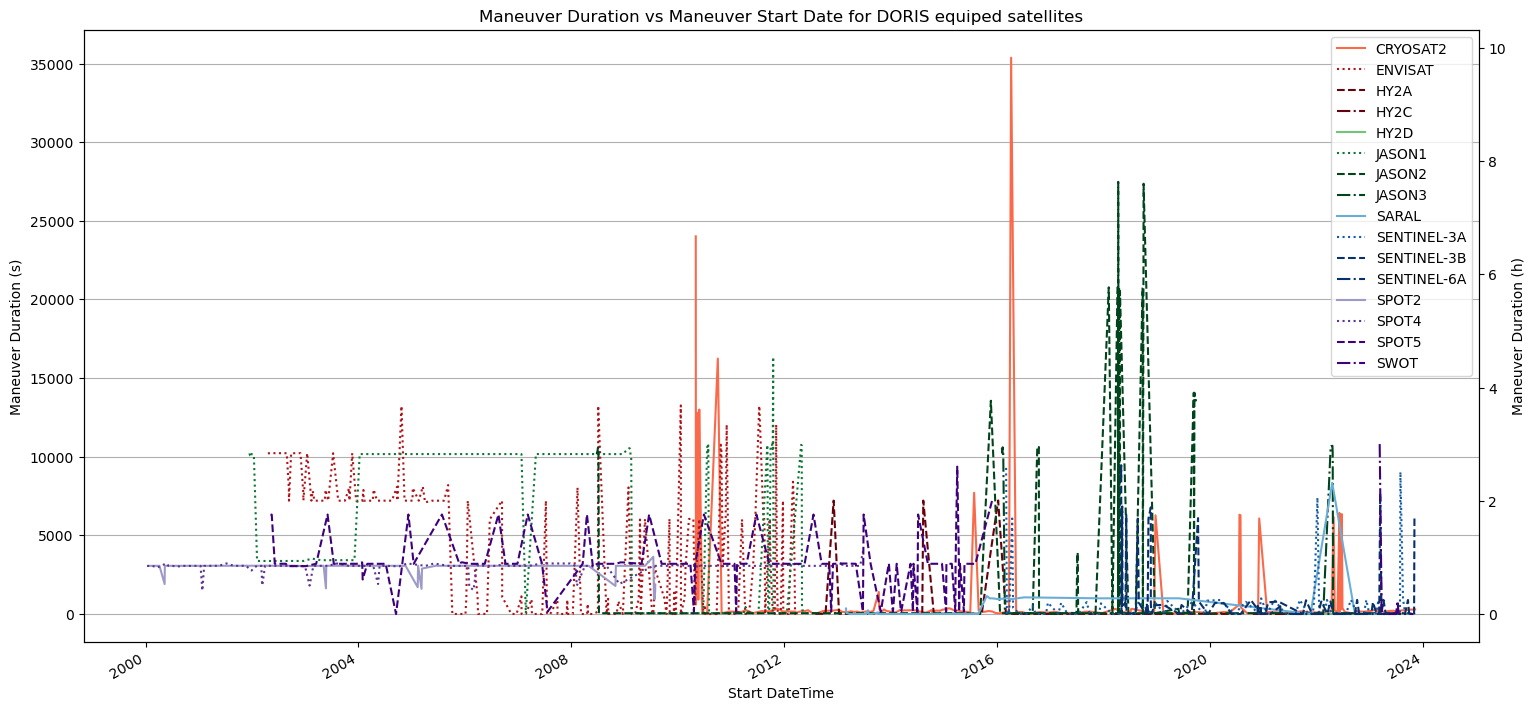

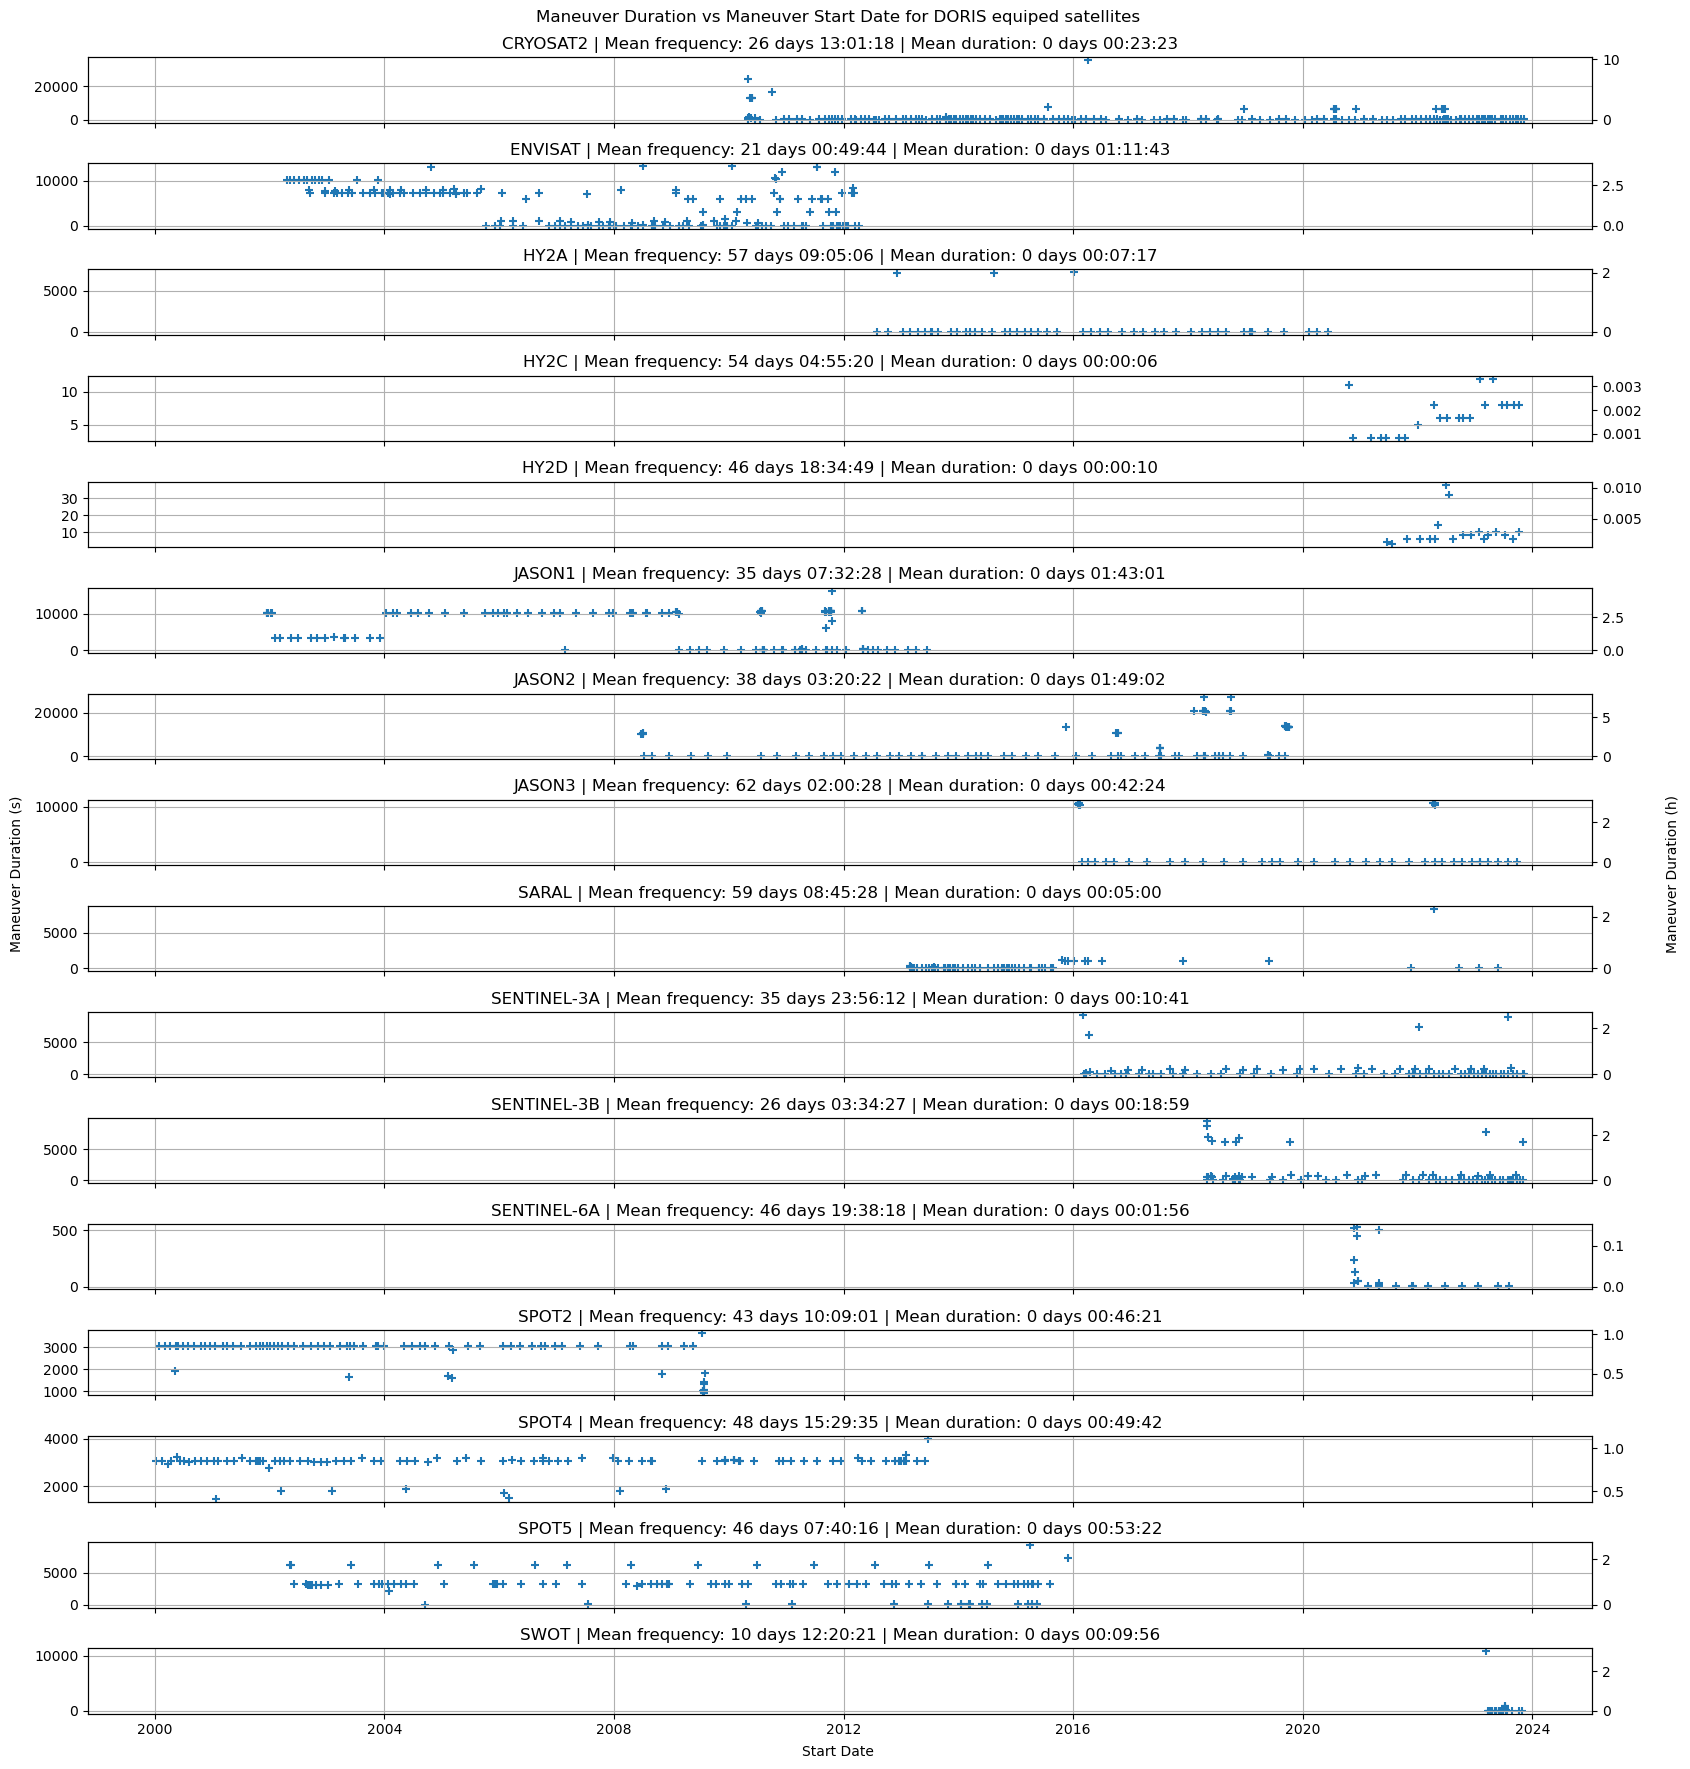

In [2]:
# Sort the DataFrame by the "Start DateTime" column
sorted_maneuvers_df = maneuvers_df.sort_values(by='Start DateTime').copy()

# Create empty dictionaries to store the results for each satellite
average_time_steps = {}
average_durations = {}
mission_durations = {}

# Get all unique satellites names
satellite_names = sorted_maneuvers_df['Satellite'].unique()

# Create a dataframe for mission statistics
missions_stats = pd.DataFrame(columns = ['Satellite', 'Start DateTime', 'End DateTime', 'Duration'])

# Calculate the average time step for each satellite
for satellite_name in satellite_names:
    # Get the dataframe of the current satellite maneuvers
    satellite_maneuvers_df = sorted_maneuvers_df[sorted_maneuvers_df['Satellite'] == satellite_name].copy()
    
    # Calculate the time step between all consecutive rows
    satellite_maneuvers_df['Time Difference'] = satellite_maneuvers_df['Start DateTime'].diff()
    
    # Compute the average time step
    average_time_step = satellite_maneuvers_df['Time Difference'].mean().round(freq='s')
    average_time_steps[satellite_name] = average_time_step
    
    ## Same thing for maneuver durations
    # Convert the "Maneuver Duration" column to timedelta
    satellite_maneuvers_df['Maneuver Duration'] = pd.to_timedelta(satellite_maneuvers_df['Maneuver Duration'])
    
    # Compute the average time difference for the current satellite type
    average_duration = satellite_maneuvers_df['Maneuver Duration'].mean().round(freq='s')
    average_durations[satellite_name] = average_duration
    
    # Calculate the time range of the satellite mission in orbit
    min_maneuver_date = satellite_maneuvers_df['Start DateTime'].min()
    max_maneuver_date = satellite_maneuvers_df['End DateTime'].max()
    mission_duration = max_maneuver_date-min_maneuver_date
    mission_durations[satellite_name] = mission_duration
    
    # New row data
    new_row = {'Satellite' : satellite_name, 
               'Start DateTime' : min_maneuver_date, 
               'End DateTime' : max_maneuver_date, 
               'Duration' : mission_duration}

    # Creating a DataFrame for the new row
    new_row_df = pd.DataFrame([new_row])

    # Concatenating the original DataFrame and the new row DataFrame
    missions_stats = pd.concat([missions_stats, new_row_df], ignore_index=True)

    
"""     print(f"{satellite_name}: in orbit between {min_maneuver_date} and {max_maneuver_date} for {mission_duration}\n",
          f"Avg maneuver frequency: {average_time_step} | Avg maneuver duration for {satellite_name}: {average_duration}") """
missions_stats.sort_values('Duration')
display(missions_stats)

shortest_mission = min(mission_durations, key=mission_durations.get)
print(f"The shortest mission is {shortest_mission} for {mission_durations[shortest_mission]}")



## Plot maneuvers for all satellites combined

# Group the data by "Satellite" and then plot the "Maneuver Duration" against "Start Date"
fig, ax = plt.subplots(figsize=(2^16, 2^11))

# Define a color map for distinguishing satellites by color
#cmap = plt.get_cmap('tab20', len(maneuvers_df['Satellite'].unique()))
#colors = itertools.cycle(cmap(np.linspace(0, 1, len(maneuvers_df['Satellite'].unique()))))

# Define the colors and the number of shades for each color
colors = ['Reds', 'Greens', 'Blues', 'Purples', 'Greys']
num_shades = 4

# Create a color map with the specified shades
color_map = []
for color in colors:
    for i in range(num_shades):
        shade = plt.cm.get_cmap(color)(0.5+i / (num_shades - 1))
        color_map.append(shade)

colors = itertools.cycle(color_map)

lines = itertools.cycle(['solid', 'dotted', 'dashed', 'dashdot'])

for satellite, group in maneuvers_df.groupby('Satellite'):
    color = next(colors)
    line = next(lines)
    group.plot(x='Start DateTime', y='Maneuver Duration Timedelta', label=satellite, ax=ax, color=color, linestyle=line)

plt.grid(axis='y')
ax.set_xlabel("Start DateTime")
ax.set_ylabel("Maneuver Duration (s)")
mn, mx = ax.get_ylim()
ax2 = ax.twinx()
ax2.set_ylim(mn/3600, mx/3600)
ax2.set_ylabel('Maneuver Duration (h)')
plt.title("Maneuver Duration vs Maneuver Start Date for DORIS equiped satellites")
legend = ax.legend(loc='upper right')

plt.show()



## Plot maneuvers for each satellites
satellites = maneuvers_df['Satellite'].unique()

num_subplots = len(satellites)

# Calculate the number of rows and columns for the subplots
num_cols = 1  # You can adjust this to the desired number of columns
num_rows = (num_subplots + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(2^16, 2^16), sharex=True)  # Make subplots share the same x-axis
fig.suptitle("Maneuver Duration vs Maneuver Start Date for DORIS equiped satellites")  # Adjust the y parameter to lift the title

# Flatten the 2D array of axes for easy indexing
axes = axes.flatten()

for i, satellite in enumerate(satellites):
    ax = axes[i]  # Get the current subplot
    
    # Filter data for the current satellite
    data_satellite = maneuvers_df[maneuvers_df['Satellite'] == satellite]
    
    # Extract x and y data
    x = pd.to_datetime(data_satellite['Start DateTime'])
    y = data_satellite['Maneuver Duration Timedelta']
    
    # Create a scatter plot
    ax.scatter(x, y, marker="+")
    
    ax.set_title(f"{satellite} | Mean frequency: {average_time_steps[satellite]} | Mean duration: {average_durations[satellite]}")  # Set the title instead of y-axis label
    
    mn, mx = ax.get_ylim()
    ax2 = ax.twinx()
    ax2.set_ylim(mn/3600, mx/3600)
    ax.grid(True)

# Set the common y-axis label (outside the loop)
fig.text(0.04, 0.5, 'Maneuver Duration (s)', va='center', rotation='vertical')

fig.text(1-0.04, 0.5, 'Maneuver Duration (h)', va='center', rotation='vertical')

# Adjust layout
fig.tight_layout(rect=[0.045, 0.012, 1-0.045, 0.99])

# Create a common x-axis label
fig.text(0.5, 0.01, 'Start Date', ha='center')

plt.show()

# TLE

## Téléchargement des données sur l'API SpaceTrack

In [3]:
norad_ids = [36508, 27386, 43682, 46469, 48621, 26997, 33105, 41240, 39086, 41335, 43437, 46984, 20436, 25260, 27421, 54754]

def spacetrack_api_query(norad_ids=norad_ids):
    # Initialize the Space-Track API client
    st = SpaceTrackClient('gregoire.marie08@gmail.com', 'Scarily-Cartridge0-Anything*')

    for norad_id in norad_ids:
        # Create an empty list to store all queries
        all_results = []

    	# Fetch first and last maneuver dates
        min_date = maneuvers_df[maneuvers_df['NoradId']==norad_id]['Start DateTime'].min().strftime("%Y-%m-%d")
        max_date = maneuvers_df[maneuvers_df['NoradId']==norad_id]['End DateTime'].max().strftime("%Y-%m-%d")

        # Convert min_date and max_date to datetime objects
        min_date = datetime.strptime(min_date, "%Y-%m-%d") - timedelta(days=7)
        max_date = datetime.strptime(max_date, "%Y-%m-%d") + timedelta(days=7)
        total_epoch = op.inclusive_range(min_date.strftime("%Y-%m-%d"), max_date.strftime("%Y-%m-%d"))
        print(f"\nTreating {norad_id} between {min_date.strftime("%Y-%m-%d")} & {max_date.strftime("%Y-%m-%d")}")

        mission_duration = max_date - min_date

        max_query_span = 5  # In years
        # Calculate the number of 5-year intervals
        num_intervals = math.ceil((max_date - min_date).days / (365 * max_query_span))

        if math.ceil(mission_duration.days / 365) > max_query_span:
            print(f"The mission spans on {mission_duration}, longer than {max_query_span} years. Query split in {num_intervals} intervals")

        # Define the output file name
        output_file_name = join(rootdir, 'data', 'tle', 'TLE_{norad_id}_{total_epoch}.json')
        
        if os.path.exists(output_file_name) and os.path.getsize(output_file_name) > 0:
            print(f"The output file {output_file_name} is not empty.")
        else:
            i=0
            while i<num_intervals:
                # Calculate the start and end dates for each interval
                interval_start = (min_date + timedelta(days=i * 365 * max_query_span))
                interval_end = (min_date + timedelta(days=(i + 1) * 365 * max_query_span))
                if interval_end > max_date:
                    interval_end = max_date

                # Set the time range to query
                query_epoch = op.inclusive_range(interval_start.strftime("%Y-%m-%d"), interval_end.strftime("%Y-%m-%d"))
                print(f"Query #{i}: {query_epoch}")

                try:
                    query = st.tle(
                        norad_cat_id=norad_id,
                        epoch=query_epoch,
                        orderby='epoch asc')
                    # Append the result to the list
                    all_results.extend(query)
                    print(f"Query #{i} successful, data extended.")
                    i+=1
                except ReadTimeout as e:
                    wait_time=30
                    print(f"Rate limit exceeded, waiting {wait_time}s")
                    time.sleep(wait_time)
                except Exception as e:
                    print(f"An exception of type {type(e).__name__} raised in query #{i}:\n{e.args}")
                    break

            assert all_results!=[], f"No data was fetched for {norad_id}"
            try:
                # Save all results as JSON to the output file
                with open(output_file_name, 'w') as output_file:
                    json.dump(all_results, output_file, indent=2)
                    print(f"All data saved to {output_file_name}")
            except Exception as e:
                print(f"An error occurred while saving to {output_file_name}: {e}")

# Query TLEs
#spacetrack_api_query()

## Calcul des résidus

In [4]:
# Directory where the TLE files are located
tle_directory = join(rootdir, 'data', 'tle')

# Get the TLE file absolute paths
tle_files = [os.path.join(tle_directory, filename) for filename in os.listdir(tle_directory)]
    
# Create a dictionary to contain the dataframe of each object's residues
# Each dataframe contain: "EPOCH" (Start Date) as key, "Inclination residue", "Eccentricity residue", ..., "Mean Motion residue", "Maneuver", "Maneuver duration"
residues_df_dict = {}

for tle_file in tle_files:
    # Read the JSON file
    if os.path.isfile(tle_file):
        with open(tle_file, 'r') as file:
            data = json.load(file)

        # Sort the data by the "EPOCH" field in ascending order
        sorted_tle = sorted(data, key=lambda x: x['EPOCH'])

        norad_id = sorted_tle[0]["NORAD_CAT_ID"]
        object_name = sorted_tle[0]["OBJECT_NAME"]

        # List the parameters we want to keep from the TLE file
        parameters = ["INCLINATION", "RA_OF_ASC_NODE", "ECCENTRICITY", "ARG_OF_PERICENTER", "MEAN_ANOMALY", "MEAN_MOTION"] #, "APOGEE", "PERIGEE", "SEMIMAJOR_AXIS"]

        # Create a dictionary to store the lists of parameters ordered by EPOCH
        parameters_dict = {}

        # Extract in a dictionary the values of the parameters from the successive TLEs
        for parameter in parameters:
            parameters_dict[parameter] = [tle[parameter] for tle in sorted_tle]
        
        # Transform the "EPOCH" of TLEs from strings to datetimes
        epochs = [datetime.strptime(tle["EPOCH"], '%Y-%m-%d %H:%M:%S') for tle in sorted_tle]

        # Creat a dictionarty to store the lists of residues
        residues_dict_tmp = {}
        
        # Leave out the first epoch to compute residues
        residues_dict_tmp["EPOCH"] = epochs[1:]

        # Compute differences
        for parameter, values in parameters_dict.items():
            tmp = []
            parameter_residues = []
            if parameter in ["RA_OF_ASC_NODE","MEAN_ANOMALY","ARG_OF_PERICENTER"]: # Need to take into account the periodicity of the parameters in degree
                for i in range(len(values) - 1):
                    diff = float(values[i + 1]) - float(values[i])
                    tmp.append((diff+180)%360-180)
            else:
                for i in range(len(values) - 1):
                    tmp.append(float(values[i + 1]) - float(values[i]))
            residues_dict_tmp[parameter] = tmp
        
        # Convert the dict to a dataframe with index "EPOCH"
        residues_df = pd.DataFrame.from_dict(residues_dict_tmp)
        residues_df.set_index("EPOCH", inplace=True)

        residues_df_dict[norad_id] = residues_df


""" # Fix erroneous values
def pop_max(norad_id, parameter_of_max):
    object_df = residues_df_dict[norad_id] # Get the dataframe of residues of the object
    error_date=abs(object_df[parameter_of_max]).idxmax() # Find the date where the parameter_of_max is max in absolute
    print(f"\nErroneous value for {norad_id} in {parameter_of_max} at {error_date}:")
    for parameter in parameters:
        max_value=object_df[object_df.index==error_date][parameter] # Get the max value of parameter_of_max (for printing)
        mean_value=object_df[parameter].mean() # Calculate the mean value to replace it with
        print(f"Replacing {max_value.item()} with {mean_value} for {parameter}")
        object_df[parameter][error_date]=object_df[parameter].mean() # Replace the erroneous with the mean

## For JASON3 :
pop_max('41240','RA_OF_ASC_NODE')

## For SARAL :
pop_max('39086','RA_OF_ASC_NODE')
pop_max('39086','ARG_OF_PERICENTER') """

print(f"residues_df_dict is of type {type(residues_df_dict)} with {len(residues_df_dict)} objects: {list(residues_df_dict.keys())}")

residues_df_dict is of type <class 'dict'> with 16 objects: ['41240', '27386', '41335', '46469', '33105', '20436', '27421', '43437', '25260', '54754', '26997', '43682', '36508', '39086', '48621', '46984']


In [5]:
object_df = residues_df_dict["25260"]
object_df[(object_df.index>datetime(2004, 10, 12)) & (object_df.index<datetime(2004, 10, 15))]

,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
EPOCH,,,,,,
2004-10-12 03:55:14,0.0004,0.2786,1.390000e-05,2.0658,-2.0668,-0.000019
2004-10-12 08:59:38,0.0010,0.2102,-1.490000e-05,5.9819,-5.9934,-0.000047
2004-10-12 10:41:06,-0.0001,0.0692,6.700000e-06,-20.2835,20.3212,0.000078
2004-10-12 20:49:53,0.0002,0.4176,-1.290000e-05,7.0901,-7.1189,-0.000018
2004-10-12 22:31:21,-0.0001,0.0696,3.200000e-06,3.2792,-3.2775,-0.000003
2004-10-13 03:35:44,-0.0001,0.2083,8.800000e-06,2.2252,-2.2265,-0.000009
2004-10-13 12:03:04,-0.0003,0.3474,2.000000e-07,-8.1202,8.1222,-0.000023
2004-10-13 18:48:55,-0.0001,0.2781,-1.240000e-05,6.5361,-6.5368,-0.000011
2004-10-13 22:11:51,-0.0001,0.1390,2.500000e-06,5.2749,-5.2752,-0.000006


## Plot des résidus

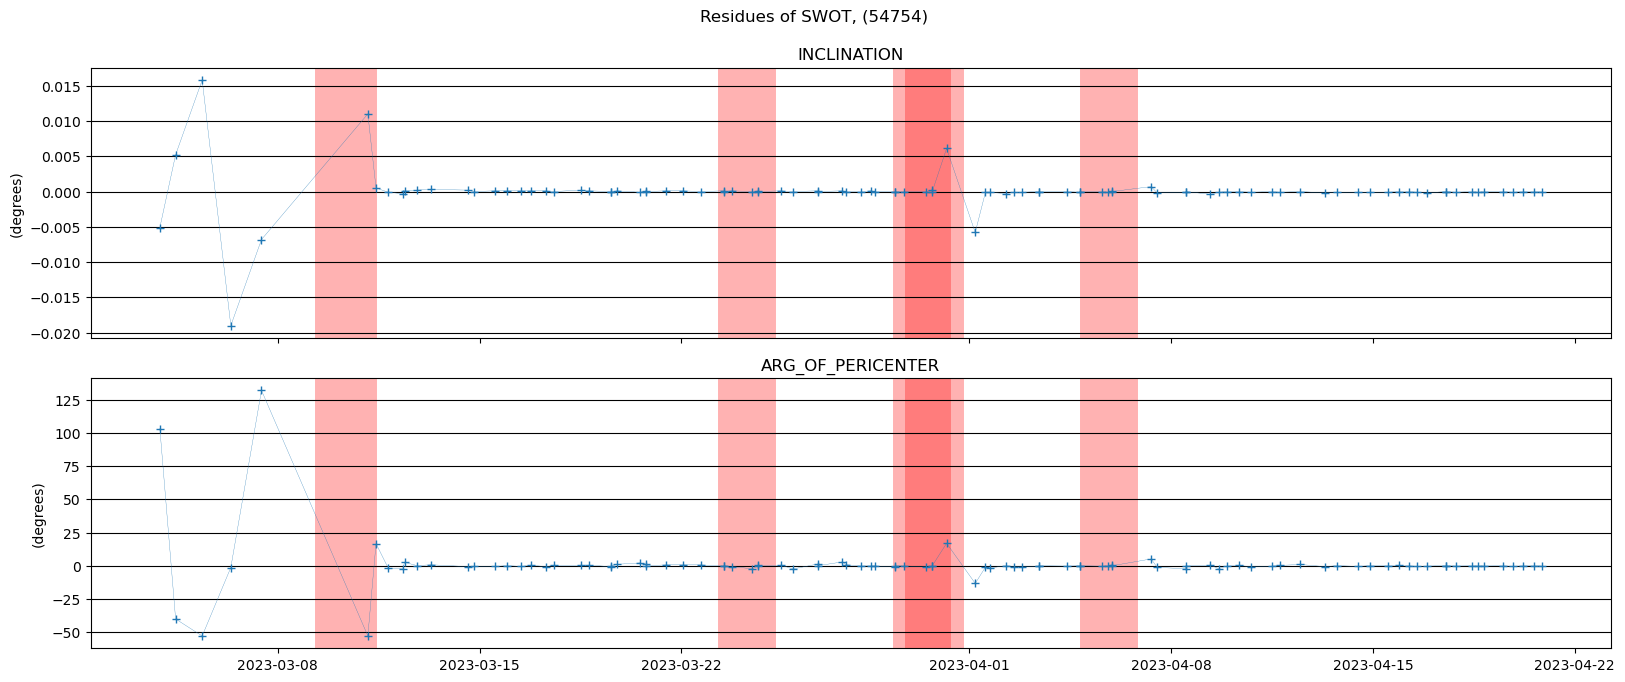

In [27]:
def plot_residues(norad_ids=residues_df_dict.keys()): # (1min long)
    #%matplotlib qt
    #%matplotlib inline
    norad_ids=[int(id) for id in norad_ids]
    for norad_id in norad_ids:
        residues_df = residues_df_dict[str(norad_id)].head(100)

        #parameters = residues_df.columns
        parameters = ["INCLINATION", "ARG_OF_PERICENTER"]
        
        # Calculate the number of rows and columns for the subplots
        num_cols = 1  # You can adjust this to the desired number of columns
        num_rows = (len(parameters) + num_cols - 1) // num_cols

        # Create subplots
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(2^16, 2^5), sharex=True)  # Make subplots share the same x-axis
        fig.suptitle(f"Residues of {dict_satellites_names[int(norad_id)]}, ({norad_id})")  # Adjust the y parameter to lift the title

        x = residues_df.index

        for i, parameter in enumerate(parameters):
            ax = axes[i]  # Get the current subplot
            # Extract x and y data
            y = residues_df[parameter]

            ax.set_title(f"{parameter}")
            ax.set_ylabel(f"{parameters_unit[parameter]}")
            
            ax.grid(axis='y', color='black')
            
            # Create a scatter plot
            ax.plot(x, y, marker="+", linewidth = '0.2')
            
            # Get the dataframe of maneuvers
            df_object_maneuvers = maneuvers_df[maneuvers_df['NoradId']==int(norad_id)]
            starts = df_object_maneuvers['Start DateTime']
            emds = df_object_maneuvers['End DateTime']

            # Plot the maneuvers
            for index, row in df_object_maneuvers.iterrows():
                maneuver_start = row['Start DateTime']
                maneuver_end = row['End DateTime']
                if x.min() < maneuver_start < x.max():
                    ax.axvspan(maneuver_start-timedelta(1), maneuver_end+timedelta(1), facecolor='r', edgecolor='r', alpha=0.3, lw=0.4, capstyle="butt")
            #ax.set_xlim(left=min(x), right=max(x))
        # Adjust layout
        fig.tight_layout(rect=[0.045, 0.012, 1-0.045, 0.99])
        fig.savefig(join(rootdir, 'results', 'residues_maneuvers', 'residues_maneuvers_{dict_satellites_names[int(norad_id)]}_{norad_id}'))

plot_residues([54754])

## Save residues and maneuvers as CSV

In [ ]:
residues_dir = join(rootdir, 'data', 'residues')

def export_residues(residues_dir):
    norad_ids=[int(id) for id in residues_df_dict.keys()]
    norad_ids.sort()
    for norad_id in norad_ids:
        residues_maneuvers = residues_df_dict[str(norad_id)].copy()
        residues_maneuvers.sort_index(inplace=True)
        
        # Add maneuvers in anomaly column
        df_object_maneuvers = maneuvers_df[maneuvers_df['NoradId']==int(norad_id)]
        df_object_maneuvers.sort_index(inplace=True)

        for index, row in df_object_maneuvers.iterrows():
            maneuver_start = row['Start DateTime']
            maneuver_end = row['End DateTime']
            
            extend_after = 3 # days
            extend_before = 1 # days
            
            mask = (residues_maneuvers.index >= (maneuver_start - timedelta(extend_before))) & (residues_maneuvers.index <= (maneuver_end + timedelta(extend_after)))
            residues_maneuvers.loc[mask, 'anomaly'] = 1.0
            
        # Fill the rest of the entries to 0.0 (no anomaly)
        residues_maneuvers['anomaly'] = residues_maneuvers['anomaly'].fillna(0.0)
        
        # Fetch first and last residues dates
        min_date = residues_maneuvers.index.min().strftime("%Y-%m-%d")
        max_date = residues_maneuvers.index.max().strftime("%Y-%m-%d")

        # Convert min_date and max_date to datetime objects
        min_date = datetime.strptime(min_date, "%Y-%m-%d")
        max_date = datetime.strptime(max_date, "%Y-%m-%d")
        total_epoch = op.inclusive_range(min_date.strftime("%Y-%m-%d"), max_date.strftime("%Y-%m-%d"))
        
        save_file = join(rootdir, 'data', 'residues', residues_dir, 'residues_{norad_id}_{total_epoch}.csv')
        residues_maneuvers.to_csv(save_file)
        print(f'Saved to: {save_file}')
        
#export_residues(residues_dir=residues_dir)

## Title


In [ ]:
# st_df_dict = residues_df_dict.copy()

# for df_name in st_df_dict.keys():
#     residues_df = st_df_dict[df_name]
#     print(residues_df)

In [ ]:
# # Sample data
# residues_df_tmp = pd.DataFrame({
#     'EPOCH': pd.to_datetime(['2023-01-01 00:00:10', '2023-02-01 00:10:00', '2023-03-01 10:00:00']),
#     'INCLINATION': [1, 2, 3]
# })

# maneuvers_df_tmp = pd.DataFrame({
#     'Start DateTime': pd.to_datetime(['2023-01-15 00:20:00', '2023-02-15 00:00:30']),
#     'Maneuver': ['Maneuver 1', 'Maneuver 2'],
#     'Maneuver Type': ['Type1', 'Type2'],
#     'Propellant Type': ['Propellant1', 'Propellant2'],
#     'Propellant Subtype': ['Subtype1', 'Subtype2'],
#     'Propellant Name': ['Name1', 'Name2']
# })

In [ ]:
# residues_df_tmp

In [ ]:
# maneuvers_df_tmp

In [ ]:
# # Sort the dataframes by EPOCH and Start DateTime
# residues_df_tmp = residues_df_tmp.sort_values(by='EPOCH')
# maneuvers_df_tmp = maneuvers_df_tmp.sort_values(by='Start DateTime')

# # Create a dictionary to map the interval
# maneuver_dict = {}
# for index, row in maneuvers_df_tmp.iterrows():
#     start_time = row['Start DateTime']
#     next_index = index + 1

#     if next_index < len(maneuvers_df_tmp):
#         end_time = maneuvers_df_tmp.loc[next_index, 'Start DateTime']
#     else:
#         end_time = pd.to_datetime('2100-01-01 00:00:00')  # A very distant future date

#     maneuver_dict[(start_time, end_time)] = row['Maneuver']

# # Initialize an empty dictionary to store maneuver columns
# maneuver_columns = {}

# # Iterate through residues_df_tmp and add the Maneuver value
# maneuver_column = []
# for index, row in residues_df_tmp.iterrows():
#     epoch = row['EPOCH']
#     matched_maneuver = None

#     for interval, maneuver in maneuver_dict.items():
#         start_time, end_time = interval
#         if start_time <= epoch < end_time:
#             matched_maneuver = maneuver
#             break

#     maneuver_column.append(matched_maneuver)

# # Add the 'Maneuver' column to residues_df_tmp
# residues_df_tmp['Maneuver'] = maneuver_column

# # Iterate through maneuvers_df_tmp to add all columns to residues_df_tmp
# for index, row in maneuvers_df_tmp.iterrows():
#     start_time = row['Start DateTime']
#     next_index = index + 1

#     if next_index < len(maneuvers_df_tmp):
#         end_time = maneuvers_df_tmp.loc[next_index, 'Start DateTime']
#     else:
#         end_time = pd.to_datetime('2100-01-01 00:00:00')  # A very distant future date

#     interval = (start_time, end_time)

#     for col in maneuvers_df_tmp.columns:
#         if col != 'Start DateTime':
#             maneuver_columns[col] = [row[col] if start_time <= epoch < end_time else None for epoch in residues_df_tmp['EPOCH']]

# # Add all columns from maneuvers_df_tmp to residues_df_tmp
# for col_name, col_data in maneuver_columns.items():
#     residues_df_tmp[col_name] = col_data

# residues_df_tmp

In [ ]:
# residues_df_tmp = st_df_dict["20436"]
# residues_df_tmp.reset_index(inplace=True)
# maneuvers_df_tmp = maneuvers_df[maneuvers_df['Satellite'] == 'ENVISAT']

In [ ]:
# residues_df_tmp

In [ ]:
# maneuvers_df_tmp

In [ ]:
# # Sort the dataframes by EPOCH and Start DateTime
# residues_df_tmp = residues_df_tmp.sort_values(by='EPOCH')
# maneuvers_df_tmp = maneuvers_df_tmp.sort_values(by='Start DateTime')

# # Create a dictionary to map the interval
# maneuver_dict = {}
# for index, row in maneuvers_df_tmp.iterrows():
#     start_time = row['Start DateTime']
#     next_index = index + 1

#     if next_index < len(maneuvers_df_tmp):
#         end_time = maneuvers_df_tmp.loc[next_index, 'Start DateTime']
#     else:
#         end_time = pd.to_datetime('2100-01-01 00:00:00')  # A very distant future date

#     maneuver_dict[(start_time, end_time)] = row['Maneuver']

# # Iterate through residues_df_tmp and add the Maneuver value
# maneuver_column = []
# for index, row in residues_df_tmp.iterrows():
#     epoch = row['EPOCH']
#     matched_maneuver = None

#     for interval, maneuver in maneuver_dict.items():
#         start_time, end_time = interval
#         if start_time <= epoch < end_time:
#             matched_maneuver = maneuver
#             break

#     maneuver_column.append(matched_maneuver)

# residues_df_tmp['Maneuver'] = maneuver_column

# residues_df_tmp

In [ ]:
# # Assuming your dataframes are already sorted by their respective columns
# # If not sorted, you can use .sort_values on each dataframe before merging

# merged_df = pd.merge_asof(maneuvers_df_tmp, residues_df_tmp, left_on='Start DateTime', right_index=True, direction='forward')

# # 'direction' parameter is set to 'forward' to ensure that 'Start DateTime' is between two consecutive 'EPOCH' values.

In [ ]:
# # Filter maneuvers_df for the rows where Satellite is "ENVISAT"
# maneuvers_df_tmp = maneuvers_df[maneuvers_df['Satellite'] == 'ENVISAT']

# # Sort the filtered_maneuvers_df and residues_df by 'Start DateTime' and EPOCH, respectively
# filtered_maneuvers_df = maneuvers_df_tmp.sort_values('Start DateTime')
# residues_df_tmp = residues_df.sort_index()

# # Use merge_asof to merge the dataframes based on 'Start DateTime' and EPOCH
# merged_df = pd.merge_asof(residues_df_tmp, filtered_maneuvers_df, left_index=True, right_on='Start DateTime', direction='forward', suffixes=('', '_maneuver'))

# # Print the resulting merged dataframe
# print(merged_df)